In [1]:
%matplotlib inline

import Levenshtein as L
import umap
import pandas as pd
import numpy as np
import networkx as nx

from matplotlib import pyplot as plt
from collections import Counter

In [44]:
for col in df.columns[5:]:
    print(col, df[col].sum())

VTEHDTLLY-IE-1-CMV 5166
KTWGQYWQV-gp100-Cancer 3147
ELAGIGILTV-MART-1-Cancer 2119
CLLWSFQTSA-Tyrosinase-Cancer 592
IMDQVPFSV-gp100-Cancer 2043
SLLMWITQV-NY-ESO-1-Cancer 2639
KVAELVHFL-MAGE-A3-Cancer 1650
KVLEYVIKV-MAGE-A1-Cancer 5706
CLLGTYTQDV-Kanamycin-B-dioxygenase 990
LLDFVRFMGV-EBNA-3B-EBV 4670
LLMGTLGIVC-HPV-16E7-82-91 254
CLGGLLTMV-LMP-2A-EBV 214
YLLEMLWRL-LMP1-EBV 1513
FLYALALLL-LMP2A-EBV 1443
GILGFVFTL-Flu-MP-Influenza 4816
GLCTLVAML-BMLF1-EBV 1553
NLVPMVATV-pp65-CMV 3186
ILKEPVHGV-RT-HIV 1905
FLASKIGRLV-Ca2-indepen-Plip-A2 2069
CYTWNQMNL-WT1-(235-243)236M-Y 2804
RTLNAWVKV-Gag-protein-HIV 1099
KLQCVDLHV-PSA146-154 2139
LLFGYPVYV-HTLV-1 2803
SLFNTVATL-Gag-protein-HIV 1902
SLYNTVATLY-Gag-protein-HIV 567
SLFNTVATLY-Gag-protein-HIV 1079
RMFPNAPYL-WT-1 1723
YLNDHLEPWI-BCL-X-Cancer 1903
MLDLQPETT-16E7-HPV 1937
KLGGALQAK-IE-1-CMV 34269
RLRAEAQVK-EMNA-3A-EBV 26040
RIAAWMATY-BCL-2L1-Cancer 14163
IVTDFSVIK-EBNA-3B-EBV 25717
AVFDRKSDAK-EBNA-3B-EBV 29558
IPSINVHHY-pp65-CMV 2155
AYAQKIFKI-

In [30]:
# df = pd.read_csv('../data/train.data')
# sequences = df['TRB']
# labels = df['A0301_KLGGALQAK_IE-1_CMV_binder']

df = pd.read_csv('../data/train_multilabel.data')
sequences = df['TRB']
labels = df['NLVPMVATV-pp65-CMV']

seq = pd.Series(sequences)
print("old:", len(seq)) 
seq = seq[(seq.str.len() >= 9) & (seq.str.len() <= 19)]
ind = seq.index
seq = seq.reset_index(drop=True)
print("new:", len(seq)) 

seq = seq.str.slice(start=2, stop=-2)        
neg = list(set(seq[labels == False]))
pos = list(set(seq[labels == True]))

print(len(neg), len(pos))

old: 41922
new: 41500
34812 3072


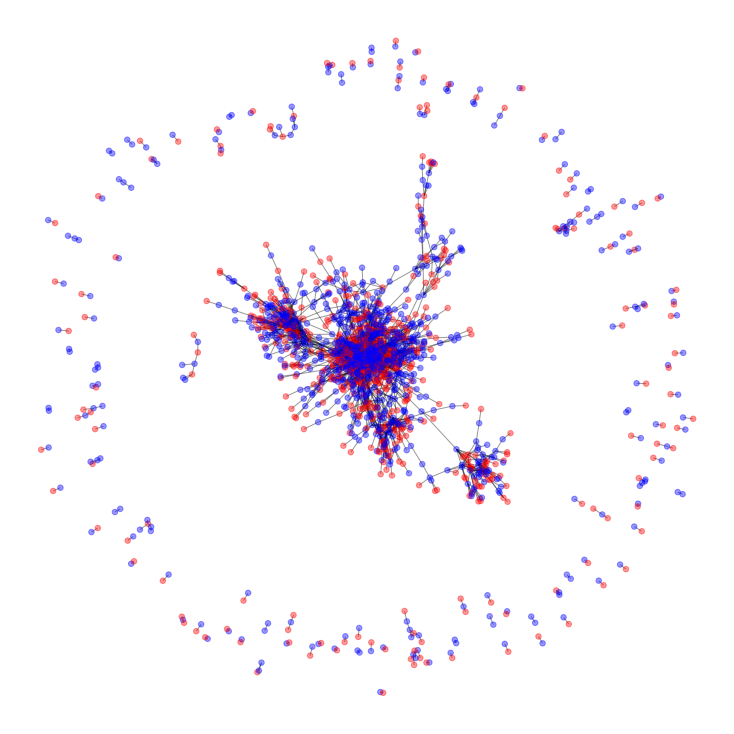

In [31]:
N = 2000
N = min(N, min(len(neg), len(pos)))
LEV_DIST = 2

# don't judge
new_neg = list(np.array(neg)[np.random.choice(len(neg), N, replace=False)])
new_pos = list(np.array(pos)[np.random.choice(len(pos), N, replace=False)])


G = nx.Graph()

for i in range(len(new_pos)):
    for j in range(len(new_neg)):
        dist_val = L.distance(new_pos[i], new_neg[j])
        
        if dist_val <= LEV_DIST:
            G.add_edge("P"+str(i), "N"+str(j))
            
for i in range(len(new_pos) - 1):
    for j in range(i+1, len(new_pos)):
        dist_val = L.distance(new_pos[i], new_pos[j])
        
        if dist_val <= LEV_DIST:
            G.add_edge("P"+str(i), "P"+str(j))

        
plt.figure(num=None, figsize=(10, 10))
nx.draw_spring(G, node_size=30, node_color = ["red" if node.startswith("N") else "blue" for node in G.nodes], alpha=.4)

In [ ]:
N = 2000
mat = np.zeros((N*2, N*2))

# new_neg = neg[:N]
# new_pos = pos[:N]

# don't judge
new_neg = list(np.array(neg)[np.random.choice(len(neg), N, replace=False)])
new_pos = list(np.array(pos)[np.random.choice(len(pos), N, replace=False)])

all_seq = new_neg + new_pos
mix_dist = []
pos_dist = []
neg_dist = []

for i in range(N*2-1):
    for j in range(i+1, N*2):
        dist_val = L.distance(all_seq[i], all_seq[j])
        mat[i,j] = dist_val
        
        if i < N:
            if j < N:
                neg_dist.append(dist_val)
            if j > N:
                mix_dist.append(dist_val)
        else:
            pos_dist.append(dist_val)
        
_ = plt.hist(neg_dist, alpha=.5, bins=20, label="neg", density=True)
_ = plt.hist(pos_dist, alpha=.5, bins=20, label="pos", density=True)
_ = plt.hist(mix_dist, alpha=.5, bins=20, label="mix", density=True)
plt.legend()

In [ ]:
emb = umap.UMAP(n_neighbors=4, metric="precomputed")

mat[mat > 5] = 100
emb = emb.fit_transform(mat)

plt.scatter(emb[:,0], emb[:,1], c=["red"]*N + ["blue"]*N, s=2, alpha=.3)